Device: cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 208MB/s]


Loaded model from: /kaggle/input/segmentation-infused-vit-model-outputs-ham10000/ham_sivit_outputs/best_sivit_model.pth
Random IDs: ['ISIC_0030287', 'ISIC_0027808', 'ISIC_0032031', 'ISIC_0033132', 'ISIC_0031742']


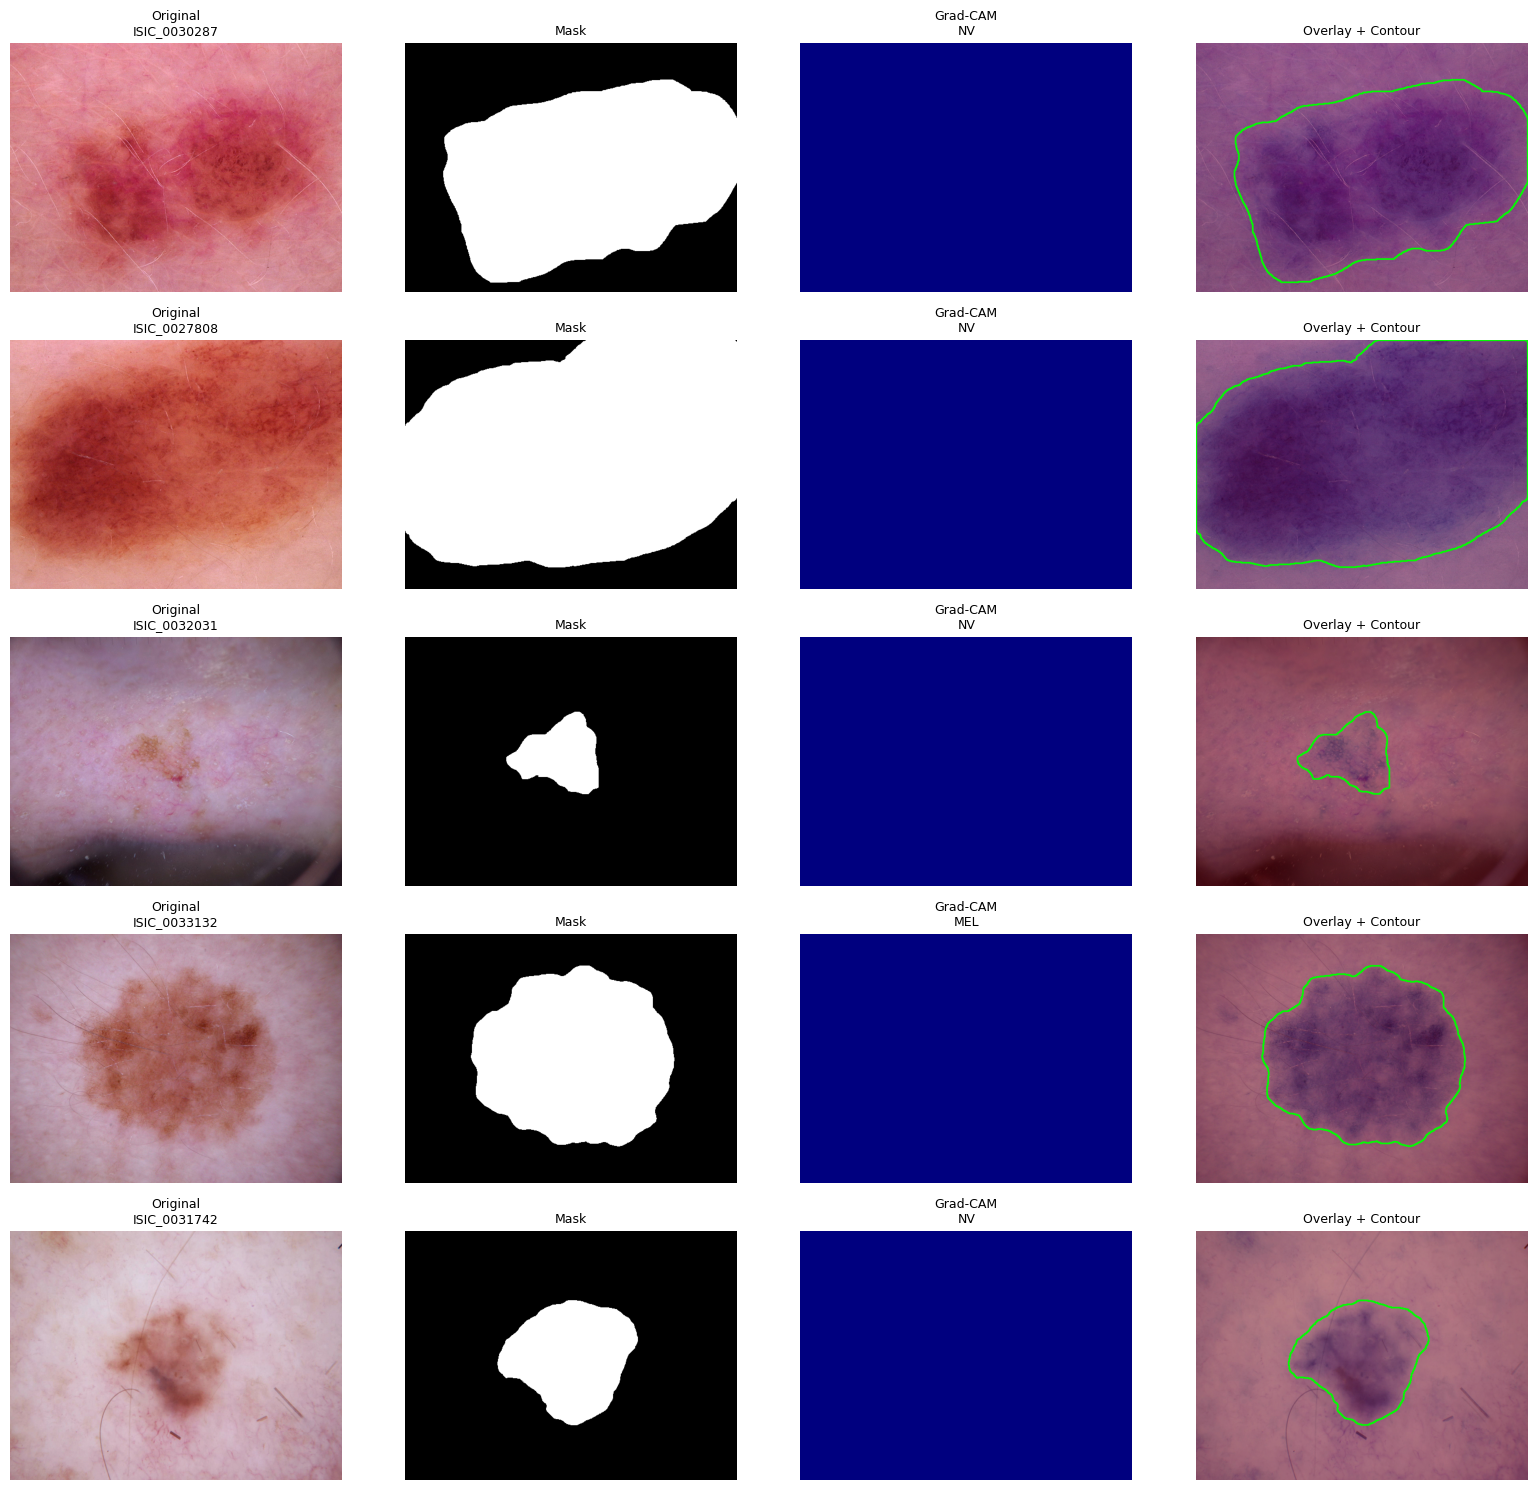

Saved Grad-CAM grid to: /kaggle/working/ham_sivit_outputs/sivit_gradcam_grid_5examples.png


In [1]:
# ============================================================
# SI-ViT Grad-CAM grid: 5 random images
# Each row: Original | Mask | Grad-CAM | Overlay + Contour
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
import pandas as pd
import random

# ---------------- CONFIG ----------------
DATA_ROOT  = Path("/kaggle/input/ham1000-segmentation-and-classification")
IMAGES_DIR = DATA_ROOT / "images"
MASKS_DIR  = DATA_ROOT / "masks"
CSV_PATH   = DATA_ROOT / "GroundTruth.csv"

# # DO NOT SAVE TO /kaggle/input — it is read-only
SIVIT_OUTPUT_DIR = Path("/kaggle/working/ham_sivit_outputs")
SIVIT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = Path("/kaggle/input/segmentation-infused-vit-model-outputs-ham10000/ham_sivit_outputs/best_sivit_model.pth")
?
IMG_SIZE = 224
N_EXAMPLES = 5    # number of random rows
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

print("Device:", DEVICE)

# ---------------- Build SI-ViT (4-channel ViT-B/16) ----------------

def build_4ch_vit_b16(num_classes=7):
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

    old_conv = vit.conv_proj
    new_conv = nn.Conv2d(
        in_channels=4,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=old_conv.bias is not None,
    )

    with torch.no_grad():
        new_conv.weight[:, :3, :, :] = old_conv.weight
        new_conv.weight[:, 3:4, :, :] = old_conv.weight.mean(dim=1, keepdim=True)

    vit.conv_proj = new_conv

    in_features = vit.heads.head.in_features
    vit.heads.head = nn.Linear(in_features, num_classes)
    return vit

model = build_4ch_vit_b16(num_classes=len(CLASS_NAMES)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Loaded model from:", MODEL_PATH)

# ---------------- Dataset helpers ----------------

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

def load_rgb_mask_4ch(image_id):
    """Returns: img_pil (original size), mask_np (H,W in {0,1}), x_4ch (1,4,224,224)"""
    img_path  = IMAGES_DIR / f"{image_id}.jpg"
    mask_path = MASKS_DIR  / f"{image_id}_segmentation.png"

    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = img_transform(img_pil)  # (3,H,W) resized

    if mask_path.exists():
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
        mask_np = np.array(mask)
        mask_bin_resized = (mask_np > 0).astype("float32")
    else:
        mask_bin_resized = np.zeros((IMG_SIZE, IMG_SIZE), dtype="float32")

    mask_tensor = torch.from_numpy(mask_bin_resized).unsqueeze(0)  # (1,H,W)
    x_4ch = torch.cat([img_tensor, mask_tensor], dim=0).unsqueeze(0)  # (1,4,H,W)

    # also load mask at original size for nicer contour
    if mask_path.exists():
        mask_orig = np.array(Image.open(mask_path).convert("L"))
        mask_orig = (mask_orig > 0).astype("uint8")
    else:
        mask_orig = np.zeros(np.array(img_pil)[:,:1].shape[:2], dtype="uint8")

    return img_pil, mask_orig, x_4ch.to(DEVICE)

# ---------------- ViT Grad-CAM (patch level) ----------------

class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.encoder_acts = None
        self.encoder_grads = None

        self.fwd_handle = model.encoder.register_forward_hook(self._save_acts)
        self.bwd_handle = model.encoder.register_full_backward_hook(self._save_grads)

    def _save_acts(self, module, inp, out):
        self.encoder_acts = out.detach()        # (B,1+N,D)

    def _save_grads(self, module, grad_input, grad_output):
        self.encoder_grads = grad_output[0].detach()  # (B,1+N,D)

    def generate(self, x, target_class=None):
        self.model.zero_grad()
        logits = self.model(x)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()

        score = logits[0, target_class]
        score.backward()

        acts  = self.encoder_acts[0]   # (1+N,D)
        grads = self.encoder_grads[0]  # (1+N,D)

        acts_p  = acts[1:, :]          # remove CLS token
        grads_p = grads[1:, :]

        token_importance = (acts_p * grads_p).sum(dim=1)  # (N,)
        token_importance = F.relu(token_importance)
        token_importance -= token_importance.min()
        if token_importance.max() > 0:
            token_importance /= token_importance.max()

        token_importance = token_importance.cpu().numpy()
        N = token_importance.shape[0]
        side = int(np.sqrt(N))         # 14 for 224x224 with patch 16
        patch_cam = token_importance.reshape(side, side)
        return patch_cam, target_class

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

gradcam = ViTGradCAM(model)

# ---------------- Choose random 5 images ----------------

df = pd.read_csv(CSV_PATH)
all_ids = df["image"].tolist()
random_ids = random.sample(all_ids, k=N_EXAMPLES)
print("Random IDs:", random_ids)

# ---------------- Build grid figure ----------------

fig, axes = plt.subplots(N_EXAMPLES, 4, figsize=(16, 3 * N_EXAMPLES))
if N_EXAMPLES == 1:
    axes = np.expand_dims(axes, axis=0)  # handle single-row case

for row_idx, image_id in enumerate(random_ids):
    img_pil, mask_orig, x_4ch = load_rgb_mask_4ch(image_id)

    # Grad-CAM
    patch_cam, pred_idx = gradcam.generate(x_4ch, target_class=None)
    pred_class = CLASS_NAMES[pred_idx]

    # Resize patch CAM to original image size
    img_np = np.array(img_pil).astype(np.float32) / 255.0
    h, w, _ = img_np.shape
    cam_resized = cv2.resize(patch_cam, (w, h), interpolation=cv2.INTER_CUBIC)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.4 * heatmap_rgb + 0.6 * img_np
    overlay = np.clip(overlay, 0, 1)

    # Make overlay with green contour from mask
    overlay_contour = (overlay * 255).astype("uint8").copy()
    cnt_mask = cv2.resize(mask_orig, (w, h), interpolation=cv2.INTER_NEAREST)

    contours, _ = cv2.findContours(cnt_mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay_contour, contours, -1, (0, 255, 0), 2)  # green

    overlay_contour = cv2.cvtColor(overlay_contour, cv2.COLOR_BGR2RGB)

    # --- Column 1: Original ---
    ax = axes[row_idx, 0]
    ax.imshow(img_pil)
    ax.set_title(f"Original\n{image_id}", fontsize=9)
    ax.axis("off")

    # --- Column 2: Mask ---
    ax = axes[row_idx, 1]
    ax.imshow(cnt_mask, cmap="gray")
    ax.set_title("Mask", fontsize=9)
    ax.axis("off")

    # --- Column 3: Grad-CAM ---
    ax = axes[row_idx, 2]
    ax.imshow(cam_resized, cmap="jet")
    ax.set_title(f"Grad-CAM\n{pred_class}", fontsize=9)
    ax.axis("off")

    # --- Column 4: Overlay + Contour ---
    ax = axes[row_idx, 3]
    ax.imshow(overlay_contour)
    ax.set_title("Overlay + Contour", fontsize=9)
    ax.axis("off")

plt.tight_layout()
grid_path = SIVIT_OUTPUT_DIR / "sivit_gradcam_grid_5examples.png"
plt.savefig(grid_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved Grad-CAM grid to:", grid_path)
